# Missing Data Strategy

In this notebook the DataFrame is now officially converted into a numeric DataFrame and a strategy for missing values is developed. The following goals are main focus here:

- Quantify NaN patterns
- Determine whether missing values carry information
- Evaluate different imputation strategies
- Decide on final strategy for preprocessing pipeline

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("notebook")

train_df = pd.read_csv("../data/raw/aps_failure_training_set.csv", header=14)
test_df = pd.read_csv("../data/raw/aps_failure_test_set.csv", header=14)

## Numeric Conversion

String-encoded missing values ("na") are converted to NaN using coercive numeric casting.
The target column `class` is excluded from conversion.

In [38]:
def convert_to_numeric(df):
    df_num = df.copy()
    for col in df_num.columns:
        if col != "class":
            df_num[col] = pd.to_numeric(df_num[col], errors="coerce")
    return df_num

numeric_train_df = convert_to_numeric(train_df)
numeric_test_df = convert_to_numeric(test_df)

## Missingness Overview

The fraction of missing values per feature is computed to understand
the overall structure and severity of missing data.


In [39]:
missing_fraction = numeric_train_df.drop(columns="class").isna().mean()
missing_fraction.describe()


count    170.000000
mean       0.083335
std        0.170596
min        0.000000
25%        0.011183
50%        0.011467
75%        0.045450
max        0.821067
dtype: float64

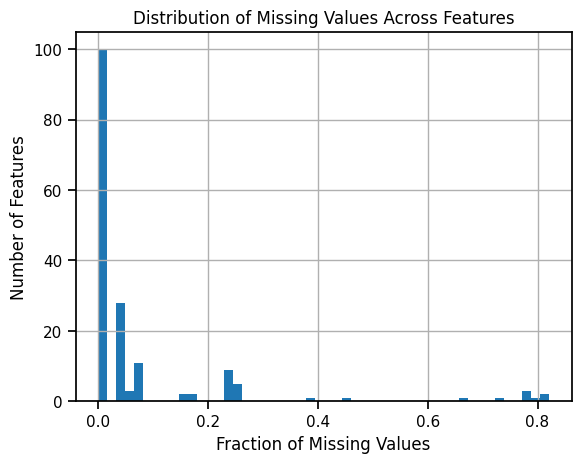

In [40]:
missing_fraction.hist(bins=50)
plt.xlabel("Fraction of Missing Values")
plt.ylabel("Number of Features")
plt.title("Distribution of Missing Values Across Features")
plt.show()

## Descriptive Statistics of Missing Values

From 170 Attributes around 140 attributes have less than 10% missing values, with almost 100 features have less than 5% missing values. There are around 10 attributes with roughly 65%-85% missing values, less than 5 attributes with around 40% missing values and around 20 attributes with roughly 20% missing values.

## Relationship Between Missingness and Target

Missing values may carry information if their occurrence is correlated with the target variable.
To test this, missingness indicators are compared across classes.

In [41]:
y = numeric_train_df["class"]

missing_by_class = (
    numeric_train_df
    .drop(columns="class")
    .isna()
    .groupby(y)
    .mean()
)

missing_by_class.T.head()

class,neg,pos
aa_000,0.000000,0.000
ab_000,0.772169,0.771
ac_000,0.048695,0.462
ad_000,0.240949,0.645
ae_000,0.036593,0.341


In [42]:
(missing_by_class.loc["pos"] - missing_by_class.loc["neg"]).sort_values(ascending=False).head(60)


ak_000    0.466441
ca_000    0.465153
di_000    0.464983
eb_000    0.464966
dk_000    0.464966
dj_000    0.464966
dl_000    0.464949
df_000    0.464949
dg_000    0.464949
dh_000    0.464949
dm_000    0.464932
ac_000    0.413305
ad_000    0.404051
ch_000    0.404051
cf_000    0.404051
co_000    0.404051
cg_000    0.404051
bz_000    0.337237
dx_000    0.337237
ar_000    0.337237
dz_000    0.337237
ea_000    0.337237
eg_000    0.337237
de_000    0.337220
ef_000    0.337220
cp_000    0.337220
dy_000    0.337220
do_000    0.337220
bc_000    0.337203
dq_000    0.337186
dr_000    0.337186
dp_000    0.337186
dv_000    0.337186
du_000    0.337186
dt_000    0.337169
bd_000    0.337169
ds_000    0.337169
cu_000    0.306983
cz_000    0.306983
db_000    0.306983
ct_000    0.306983
dc_000    0.306983
da_000    0.306983
cy_000    0.306983
cv_000    0.306983
cx_000    0.306983
af_000    0.304407
ae_000    0.304407
bf_000    0.304407
av_000    0.304407
ax_000    0.304390
ce_000    0.304373
dd_000    0.

Displaying the first 60 rows one can see that for 17 attributes the missing values differ at around 40-46% between pos and neg. 37 Attributes show a difference of between 30-33% of NaN occurrences between pos and neg labels. Two attributes show a difference of around 15 and 13% and the rest (114) have differences of less than 10%.

## Candidate Imputation Strategies

The following strategies are considered:

1. Mean / median imputation
2. Constant-value imputation (e.g. -1)
3. Imputation with missingness indicators
4. Feature removal for extreme missingness


## Median Imputation
Median imputation is robust to outliers but reduces variance by concentrating missing values at a single point. This collapses uncertainty and could distort the feature distribution.

In [43]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(strategy="median")

X_train_median = median_imputer.fit_transform(
    numeric_train_df.drop(columns="class")
)


## Constant Imputation

This is a simple method which is especially good for tree-based models since the constant value (e.g. -1) represents a separate region with easy decision making. For linear models, constant imputation introduces artificial numeric meaning, shifting feature distributions and potentially biasing learned coefficients.

In [44]:
constant_imputer = SimpleImputer(strategy="constant", fill_value=-1)

X_train_const = constant_imputer.fit_transform(
    numeric_train_df.drop(columns="class")
)


## Median + Missingness Indicators

Missing values are again replaced by the median of all remaining values. Additionally a flag is created, which gives information on whether the value was missing (True) or whether it is a real measurement (False). A model can take this information into consideration while it is being built, which can be an advantage compared to replacing missing values by either the median or a constant value.

In [45]:
from sklearn.impute import MissingIndicator

indicator = MissingIndicator(features="missing-only")

X_missing = indicator.fit_transform(
    numeric_train_df.drop(columns="class")
)

X_imputed = median_imputer.fit_transform(
    numeric_train_df.drop(columns="class")
)

X_train_with_indicators = np.hstack([X_imputed, X_missing])


In [46]:
high_missing_features_09 = missing_fraction[missing_fraction > 0.9].index.tolist()
high_missing_features_08 = missing_fraction[missing_fraction > 0.8].index.tolist()
high_missing_features_07 = missing_fraction[missing_fraction > 0.7].index.tolist()
high_missing_features_06 = missing_fraction[missing_fraction > 0.6].index.tolist()
high_missing_features_05 = missing_fraction[missing_fraction > 0.5].index.tolist()
high_missing_features_04 = missing_fraction[missing_fraction > 0.4].index.tolist()
high_missing_features_03 = missing_fraction[missing_fraction > 0.3].index.tolist()
high_missing_features_02 = missing_fraction[missing_fraction > 0.2].index.tolist()
high_missing_features_01 = missing_fraction[missing_fraction > 0.1].index.tolist()

len(high_missing_features_09),len(high_missing_features_08),len(high_missing_features_07),len(high_missing_features_06),len(high_missing_features_05),len(high_missing_features_04),len(high_missing_features_03),len(high_missing_features_02),len(high_missing_features_01)

(0, 2, 7, 8, 8, 9, 10, 24, 28)

## Chosen Missing Data Strategy

From the strategies shown in this notebook, the median with missingness indicators is chosen. This strategy is model-agnostic and performs well for both linear and tree-based models, as it preserves information about missingness without imposing artificial numeric meaning.
With a rather small number of features missing more than 50% of the data and no feature with more than 90% of the data missing, for now all attributes are kept for model training. Even at a 50% missingness threshold, only eight features would be removed, suggesting that aggressive feature removal based solely on missingness is not justified at this stage.